In [23]:
import random

import matplotlib.pyplot as plt
import netrd
import networkx as nx
import numpy as np

from graphinference import inference_methods, metrics

random.seed(111)
np.random.seed(111)

# Dynamic Simulations Using the `netrd` package

In [2]:
# Build a stochastic block model network with three clusters.
cluster_sizes = [20, 10, 10]
cluster_connection_probs = [
    [.5, .05, .1],
    [.05, .5, .2],
    [.1, .2, .5],
]
num_nodes = sum(cluster_sizes)

G = nx.stochastic_block_model(cluster_sizes, cluster_connection_probs)
adj = nx.adjacency_matrix(G).todense()

## Kuramoto Model

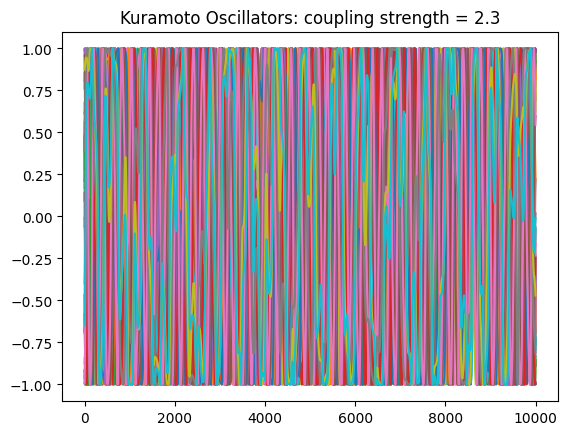

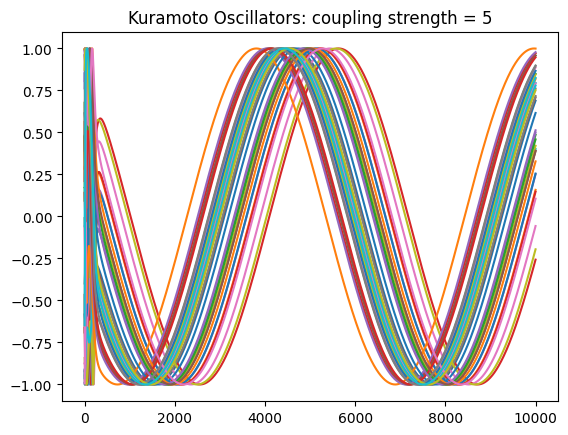

In [3]:

timeseries_length = 10000
timestep = 0.1
coupling_str = 2.3
# Initial phases distributed uniformly in [0, 2pi]
initial_phases = 2*np.pi*np.random.rand(num_nodes)
initial_freqs = np.random.rand(num_nodes) - .5

kuramoto_model = netrd.dynamics.Kuramoto()
X = kuramoto_model.simulate(
    G, 
    timeseries_length,
    strength=coupling_str,
    dt=timestep,
    phases=initial_phases,
    freqs=initial_freqs 
)

plt.title(f"Kuramoto Oscillators: coupling strength = {coupling_str}")
plt.plot(np.sin(X.T))
plt.show()

coupling_str = 5
X2 = kuramoto_model.simulate(
    G, 
    timeseries_length,
    strength=coupling_str,
    dt=timestep,
    phases=initial_phases,
    freqs=initial_freqs 
)

plt.title(f"Kuramoto Oscillators: coupling strength = {coupling_str}")
plt.plot(np.sin(X2.T))
plt.show()

This is an interesting model. We could add noise and try to predict which oscilators are coupled to which. Would VAR be able to solve this? Probably not.

We could let coupling vary with time and be an exogenous input (although we would probably have to code our own version to do that).

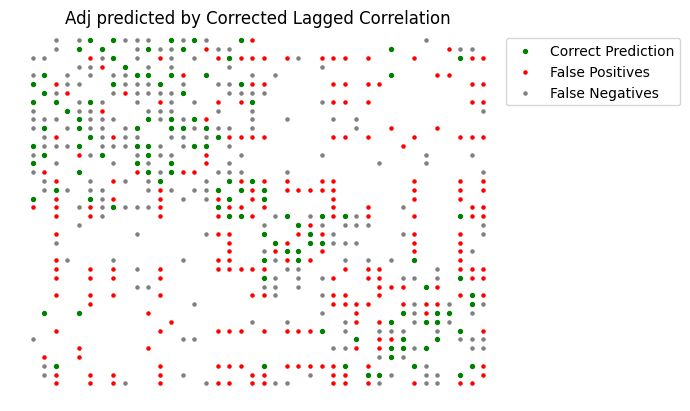

Predicted Adj Shape (40, 40) 
True Adj Shape (40, 40) 
Number of edges: 360 
True Pos: 118 	 False Pos: 242 
False Neg: 242 	 True Neg: 998 
Precision: 0.3277777777777778 
Recall: 0.3277777777777778 
F1 Score: 0.3277777777777778


0.3277777777777778

In [4]:
kuramoto_ts = np.sin(X2)
predicted_adj = inference_methods.lagged_correlation_corrected_for_reverse_causation(kuramoto_ts, np.sum(adj))

metrics.compare_adj_plot(adj, predicted_adj, title="Adj predicted by Corrected Lagged Correlation")
_ = metrics.compare_adj_f1_score(adj, predicted_adj, verbose=True)

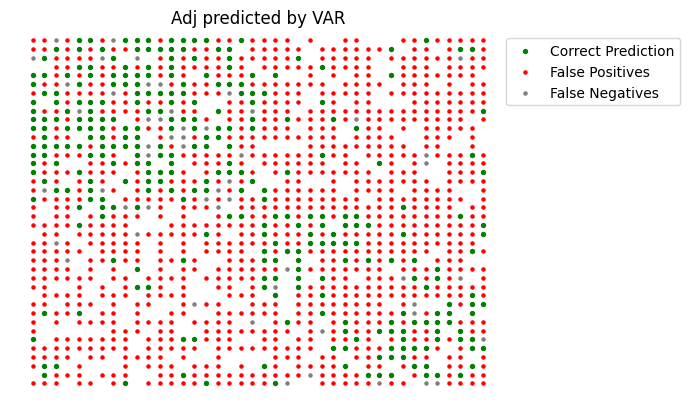

Predicted Adj Shape (40, 40) 
True Adj Shape (40, 40) 
Number of edges: 360 
True Pos: 306 	 False Pos: 984 
False Neg: 54 	 True Neg: 256 
Precision: 0.2372093023255814 
Recall: 0.85 
F1 Score: 0.3709090909090909


0.3709090909090909

In [5]:
kuramoto_ts = np.sin(X)
predicted_adj = inference_methods.vector_autoregression(kuramoto_ts, np.sum(adj))

metrics.compare_adj_plot(adj, predicted_adj, title="Adj predicted by VAR")
_ = metrics.compare_adj_f1_score(adj, predicted_adj, verbose=True)

/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/netrd/utilities/threshold.py:126: RuntimeWarning: Setting 'avg_k' argument is strongly encouraged. Using average degree of 1 for thresholding.
  warnings.warn(


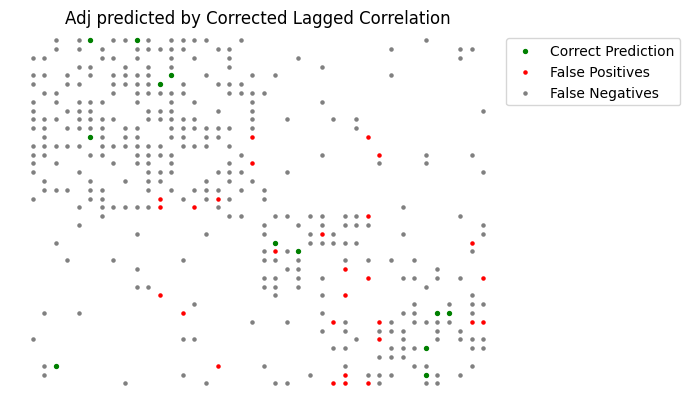

Predicted Adj Shape (40, 40) 
True Adj Shape (40, 40) 
Number of edges: 360 
True Pos: 12 	 False Pos: 28 
False Neg: 348 	 True Neg: 1212 
Precision: 0.3 
Recall: 0.03333333333333333 
F1 Score: 0.060000000000000005


0.060000000000000005

In [6]:
mle_model = netrd.reconstruction.MaximumLikelihoodEstimation()
mle_G = mle_model.fit(np.sin(X))

predicted_adj = mle_model.results["thresholded_matrix"]
predicted_adj = (predicted_adj != 0).astype(float)


metrics.compare_adj_plot(adj, predicted_adj, title="Adj predicted by MLE")
_ = metrics.compare_adj_f1_score(adj, predicted_adj, verbose=True)

## Lotka-Volterra Model

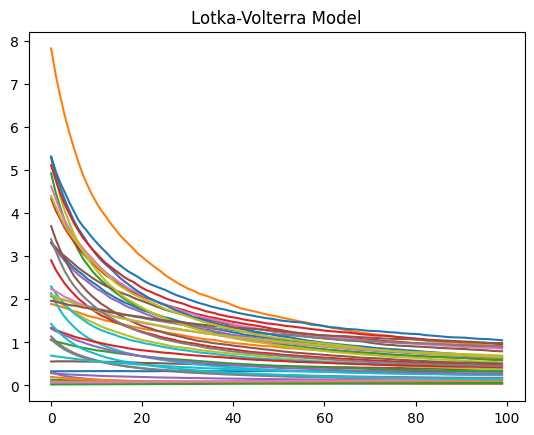

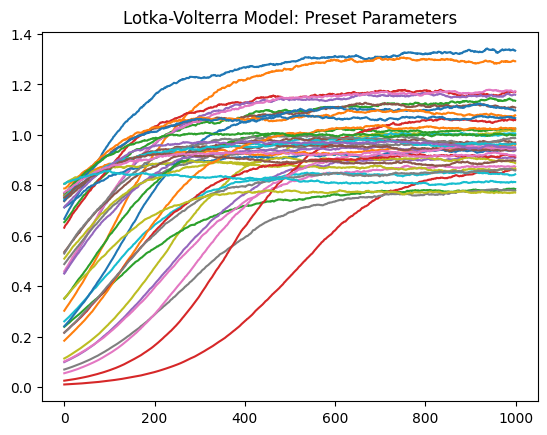

In [7]:
timeseries_length = 100

lv_model = netrd.dynamics.LotkaVolterra()
growth_rate = 0.1 * np.random.rand(num_nodes)
capacity = np.random.rand(num_nodes) * 10
initial_abundance = np.diag(capacity) @ np.random.rand(num_nodes) 

X = lv_model.simulate(
    G,
    timeseries_length,
    init=initial_abundance,
    gr=growth_rate,
    cap=capacity,
    inter=None,
    dt=timestep,
    stochastic=True,
    pertb=None,
)

plt.plot(X.T)
plt.title("Lotka-Volterra Model")
plt.show()

X = lv_model.simulate(
    G,
    1000,
)

plt.plot(X.T)
plt.title("Lotka-Volterra Model: Preset Parameters")

plt.show()

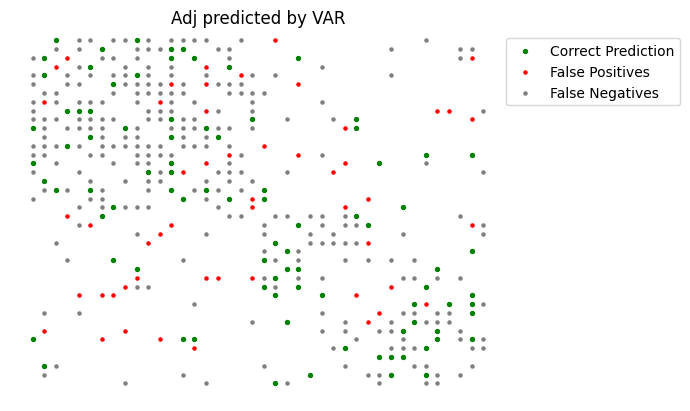

Predicted Adj Shape (40, 40) 
True Adj Shape (40, 40) 
Number of edges: 360 
True Pos: 89 	 False Pos: 52 
False Neg: 271 	 True Neg: 1188 
Precision: 0.6312056737588653 
Recall: 0.24722222222222223 
F1 Score: 0.35528942115768464


0.35528942115768464

In [12]:
lotka_ts = X
predicted_adj = inference_methods.vector_autoregression(lotka_ts, np.sum(adj))


metrics.compare_adj_plot(adj, predicted_adj, title="Adj predicted by VAR")
_ = metrics.compare_adj_f1_score(adj, predicted_adj, verbose=True)

## Ising Glauber Model 

In [9]:
# Parameters
timeseries_length = 200
init_state = (np.random.rand(num_nodes) < 0.5).astype(float)
temprature = 3.7

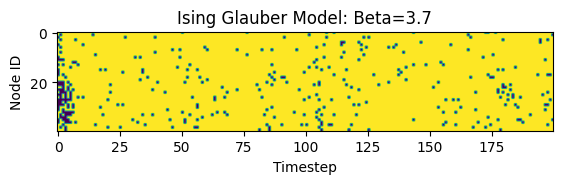

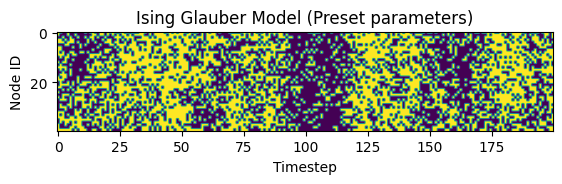

In [14]:
ig_model = netrd.dynamics.IsingGlauber()
X = ig_model.simulate(G, timeseries_length, init=init_state, beta=temprature)

plt.imshow(X)
plt.title(f"Ising Glauber Model: Beta={temprature}")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

ig_model = netrd.dynamics.IsingGlauber()
X = ig_model.simulate(G, timeseries_length, init=init_state)

plt.imshow(X)
plt.title("Ising Glauber Model (Preset parameters)")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

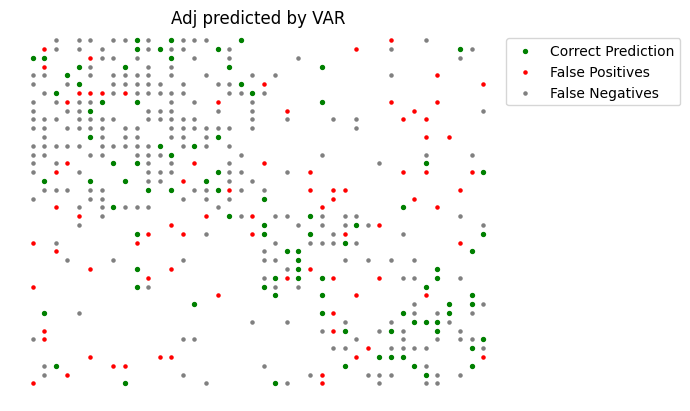

Predicted Adj Shape (40, 40) 
True Adj Shape (40, 40) 
Number of edges: 360 
True Pos: 94 	 False Pos: 81 
False Neg: 266 	 True Neg: 1159 
Precision: 0.5371428571428571 
Recall: 0.2611111111111111 
F1 Score: 0.35140186915887855


In [15]:
ising_ts = X
predicted_adj = inference_methods.vector_autoregression(ising_ts, np.sum(adj))


metrics.compare_adj_plot(adj, predicted_adj, title="Adj predicted by VAR")
_ = metrics.compare_adj_f1_score(adj, predicted_adj, verbose=True)

## SIS Model

In [24]:
# Parameters
timeseries_length = 200
initial_infected = 5
infection_rate = 0.15
recovery_rate = 0.5


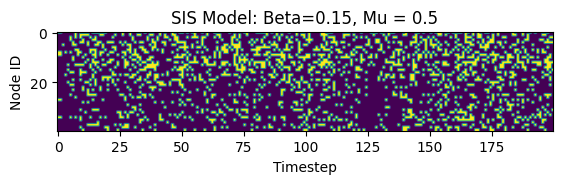

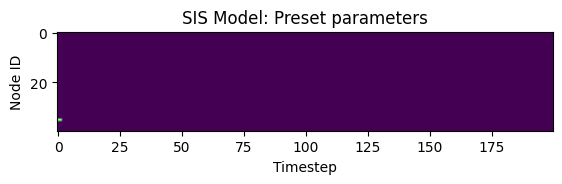

In [25]:
sis_model = netrd.dynamics.SISModel()
X = sis_model.simulate(
    G,
    timeseries_length,
    num_seeds=initial_infected,
    beta=infection_rate,
    mu=recovery_rate
)

plt.imshow(X)
plt.title(f"SIS Model: Beta={infection_rate}, Mu = {recovery_rate}")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

X2 = sis_model.simulate(G, timeseries_length)

plt.imshow(X2)
plt.title(f"SIS Model: Preset parameters")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

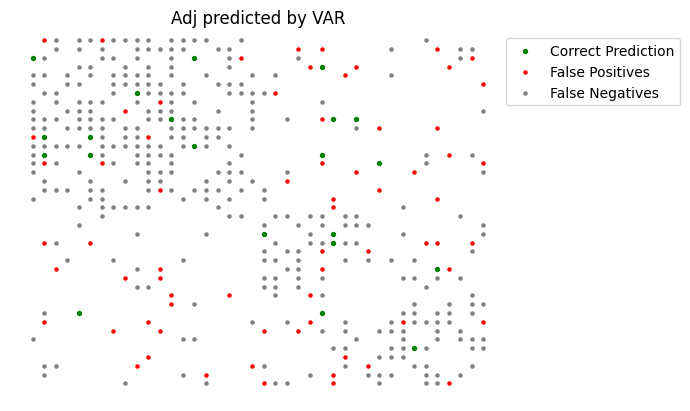

Predicted Adj Shape (40, 40) 
True Adj Shape (40, 40) 
Number of edges: 360 
True Pos: 21 	 False Pos: 69 
False Neg: 339 	 True Neg: 1171 
Precision: 0.23333333333333334 
Recall: 0.058333333333333334 
F1 Score: 0.09333333333333334


In [26]:
sis_ts = X
predicted_adj = inference_methods.vector_autoregression(sis_ts, np.sum(adj))

metrics.compare_adj_plot(adj, predicted_adj, title="Adj predicted by VAR")
_ = metrics.compare_adj_f1_score(adj, predicted_adj, verbose=True)

## Voter Model

In [19]:
# Parameters
noise_level = 0.05

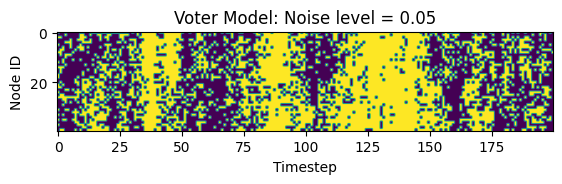

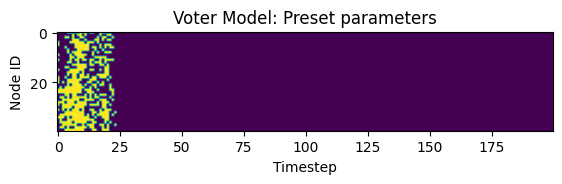

In [20]:
voter_model = netrd.dynamics.VoterModel()

X = voter_model.simulate(
    G,
    timeseries_length,
    noise=noise_level
)

plt.imshow(X)
plt.title(f"Voter Model: Noise level = {noise_level}")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

X2 = voter_model.simulate(G, timeseries_length)

plt.imshow(X2)
plt.title(f"Voter Model: Preset parameters")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

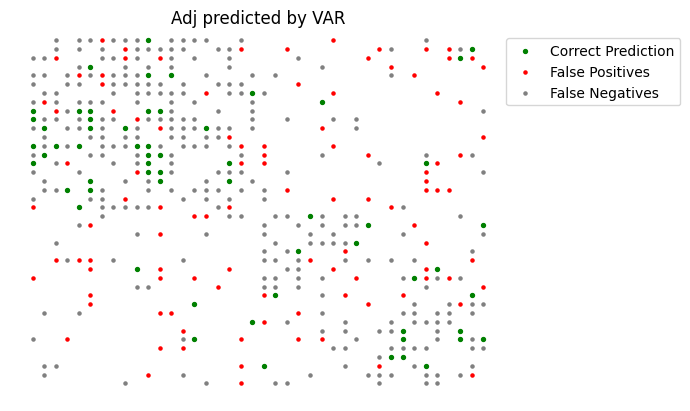

Predicted Adj Shape (40, 40) 
True Adj Shape (40, 40) 
Number of edges: 360 
True Pos: 61 	 False Pos: 105 
False Neg: 299 	 True Neg: 1135 
Precision: 0.3674698795180723 
Recall: 0.16944444444444445 
F1 Score: 0.2319391634980989


In [21]:
voter_ts = X
predicted_adj = inference_methods.vector_autoregression(voter_ts, np.sum(adj))

metrics.compare_adj_plot(adj, predicted_adj, title="Adj predicted by VAR")
_ = metrics.compare_adj_f1_score(adj, predicted_adj, verbose=True)

## Branching Process

In [ ]:
# Parameters

timeseries_length = 200
initial_fraction_active = 0.5
branching_ratio = 0.9
desired_average_activity = 0.0

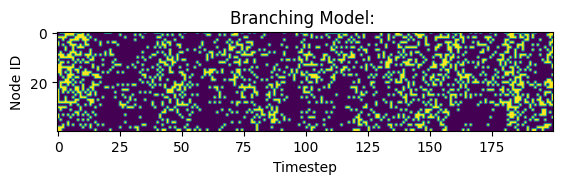

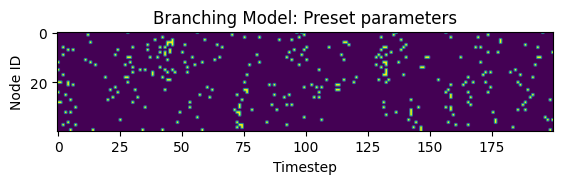

In [ ]:
branching_model = netrd.dynamics.BranchingModel()

X = branching_model.simulate(
    G,
    timeseries_length,
    initial_fraction=initial_fraction_active,
    m =branching_ratio,
    target_Ahat=desired_average_activity,
)

plt.imshow(X)
plt.title(f"Branching Model: ")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

X = branching_model.simulate(G, timeseries_length)

plt.imshow(X)
plt.title(f"Branching Model: Preset parameters")
plt.xlabel("Timestep")
plt.ylabel("Node ID")
plt.show()

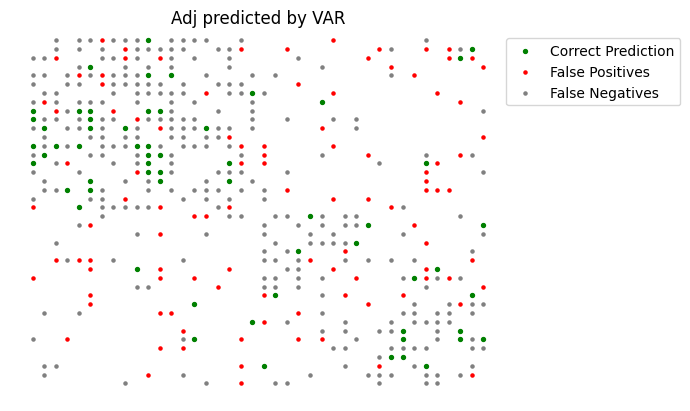

Predicted Adj Shape (40, 40) 
True Adj Shape (40, 40) 
Number of edges: 360 
True Pos: 61 	 False Pos: 105 
False Neg: 299 	 True Neg: 1135 
Precision: 0.3674698795180723 
Recall: 0.16944444444444445 
F1 Score: 0.2319391634980989


In [22]:
branching_ts = X
predicted_adj = inference_methods.vector_autoregression(branching_ts, np.sum(adj))

metrics.compare_adj_plot(adj, predicted_adj, title="Adj predicted by VAR")
_ = metrics.compare_adj_f1_score(adj, predicted_adj, verbose=True)